In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext rpy2.ipython

In [4]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from kaggle.house_prices import api
from kaggle.house_prices import helpers
from kaggle.house_prices import model_selection
from kaggle.house_prices import utils
from kaggle.house_prices.notebook import Plot, ggplot2

################################
# load data, missing, outliers #
################################
combined_dataset_step1 = api.stage1_transformation(helpers.load_data())
combined_dataset_step1.shape

################################
# transform numeric predictors #
################################
combined_dataset_step2, trans_config = api.stage2_transformation(
    combined_dataset_step1,
    threshold=20
)

trans_config

utils.frames_diff(
    combined_dataset_step1.drop(columns=['price_log']),
    combined_dataset_step2.drop(columns=['price_log'])
).head()

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 = api.stage3_transformation(combined_dataset_step2)

utils.frames_diff(
    combined_dataset_step2.drop(columns=['price_log']),
    combined_dataset_step3.drop(columns=['price_log'])
).head()

(2917, 81)

,var,progress_score,tran,tran_fn,r2_x,r2_tran
0,GrLivArea,91.157942,log,<function stage2_transformation.<locals>.<lamb...,0.525931,0.543804
3,LotArea,78.864026,inv4,<function stage2_transformation.<locals>.<lamb...,0.067883,0.159187
4,TotRmsAbvGrd,30.685015,log,<function stage2_transformation.<locals>.<lamb...,0.289123,0.293868


,GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2
0,1710,7.444833,8450,9.587694,8,2.197225
1,1262,7.141245,9600,9.898464,6,1.945910
2,1786,7.488294,11250,10.298836,6,1.945910
3,1717,7.448916,9550,9.885550,7,2.079442
4,2198,7.695758,14260,10.927728,9,2.302585


,Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,...,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
0,_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
1,_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
2,_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
3,_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,...,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
4,_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,...,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


In [6]:
train_data = (
    combined_dataset_step3
    .query("dataSource == 'train'")
    .drop(columns=['dataSource'])
)

mod = smf.ols(formula='price_log ~ GrLivArea + OverallQual', data=train_data).fit()
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.764    
Dependent Variable: price_log        AIC:                -637.7728
Date:               2018-03-20 09:31 BIC:                -621.9183
No. Observations:   1458             Log-Likelihood:     321.89   
Df Model:           2                F-statistic:        2358.    
Df Residuals:       1455             Prob (F-statistic): 0.00     
R-squared:          0.764            Scale:              0.037728 
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     7.6589     0.1260   60.7671   0.0000   7.4117   7.9061
GrLivArea     0.4566     0.0194   23.4978   0.0000   0.4185   0.4947
OverallQual   0.1719     0.0047   36.8759   0.0000   0.1627   0.1810
------------------------------------------------------------------
Omnibus:             190.057       Durbin-Watson:          1.965  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       403.151
Skew:                -0.774        Prob(JB):               0.000  
Kurtosis:            5.060         Condition No.:          240    
==================================================================

"""

In [23]:
def augment(model_results):
    predictors = [
        f.name() for f in 
        model_results.model.data.design_info.factor_infos.keys()
    ]
    df_pred = model_results.model.data.orig_exog[predictors]
    df_target = model_results.model.data.orig_endog
    return (
        pd.concat([df_target, df_pred], axis=1)
        .assign(
            resid=model_results.resid,
            fitted=model_results.fittedvalues
        )
    )

x = augment(mod)
x.head()

,price_log,GrLivArea,OverallQual,resid,fitted
0,12.247694,7.444833,7.0,-0.013333,12.261027
1,12.109011,7.141245,6.0,0.158458,11.950552
2,12.317167,7.488294,7.0,0.036297,12.280870
3,11.849398,7.448916,7.0,-0.413493,12.262891
4,12.429216,7.695758,8.0,-0.118241,12.547457


In [12]:
from IPython.display import Image, display
from rpy2.robjects import pandas2ri
from rpy2.robjects.lib import (grdevices, ggplot2)
from rpy2.robjects.packages import importr

pandas2ri.activate()

gridExtra = importr("gridExtra")

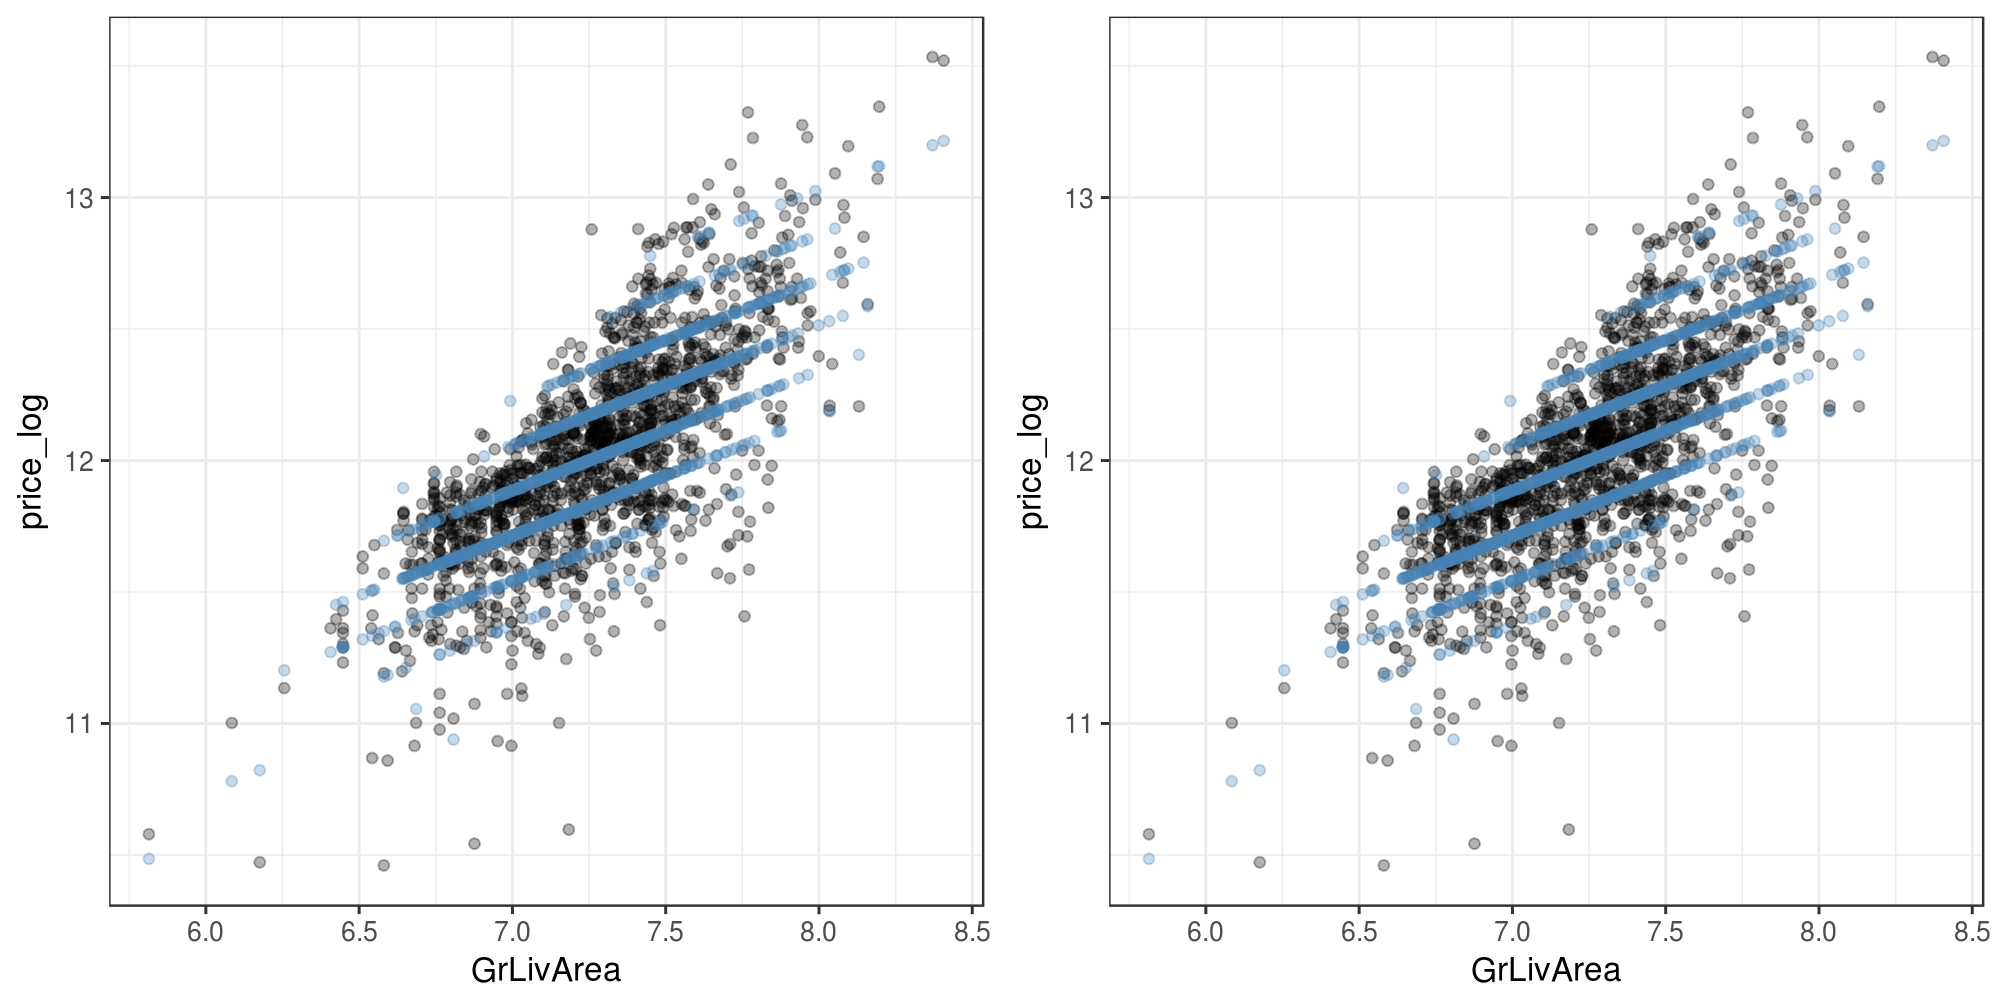

In [35]:
with grdevices.render_to_bytesio(grdevices.png, width=2000, height=1000, res=200) as img:
    p1 = (
        ggplot2.ggplot(x) +
        ggplot2.geom_point(ggplot2.aes_string(x='GrLivArea', y='price_log'), alpha=0.3) +
        ggplot2.geom_point(ggplot2.aes_string(x='GrLivArea', y="fitted"), alpha=0.3, color='steelblue') +
        ggplot2.theme_bw()
    )
    p2 = (
        ggplot2.ggplot(x) +
        ggplot2.geom_point(ggplot2.aes_string(x='GrLivArea', y='price_log'), alpha=0.3) +
        ggplot2.geom_point(ggplot2.aes_string(x='GrLivArea', y="fitted"), alpha=0.3, color='steelblue') +
        ggplot2.theme_bw()
    )
    _ = gridExtra.grid_arrange(p1, p2, ncol=2)
    
display(Image(data=img.getvalue(), format='png', embed=True))